# 5. Example: 4DVar Backprop DA using Reservoir Computing ML Model on QGS Model - RayTune for HyperParams

Using Reservoir Computing model macro-parameters from QGS/Jason Platt's paper: Platt, J. A., Wong, A., Clark, R., Penny, S. G. & Abarbanel, H. D. I. Robust forecasting using predictive generalized synchronization in reservoir computing. Chaos: An Interdisciplinary Journal of Nonlinear Science 31, 123118 (2021).


In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle
from qgs.params.params import QgParams
from timeit import default_timer as timer
import pandas as pd

from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

In [ ]:
!mkdir -p out/qgs

In [2]:
random_seed=50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [3]:
# Time parameters
dt = 0.5
# transient time to attractor
transient_time = 1.e5
# integration time on the attractor
integration_time = 1.e4


# Setting some model parameters
# Model parameters instantiation with some non-default specs
model_params = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_params.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_params.ground_params.set_orography(0.2, 1)
model_params.atemperature_params.set_thetas(0.2, 0)

In [4]:
train_size = 100000
transient_size = 1000
valid_size = 10000
test_size = 10000

In [5]:
nature_run = dab.data.QGS(model_params=model_params, store_as_jax=False, delta_t=dt,
                          random_seed=random_seed)
nature_run.generate(n_steps=200*1000, stride=1000, x0=np_rng.random(model_params.ndim)*0.001, mxstep=5000)
x0 = nature_run.values[-1]

In [6]:
nature_run.generate(x0=x0, n_steps=(train_size +  valid_size + transient_size + test_size), mxstep=5000)

In [8]:
nr_train, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    train_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


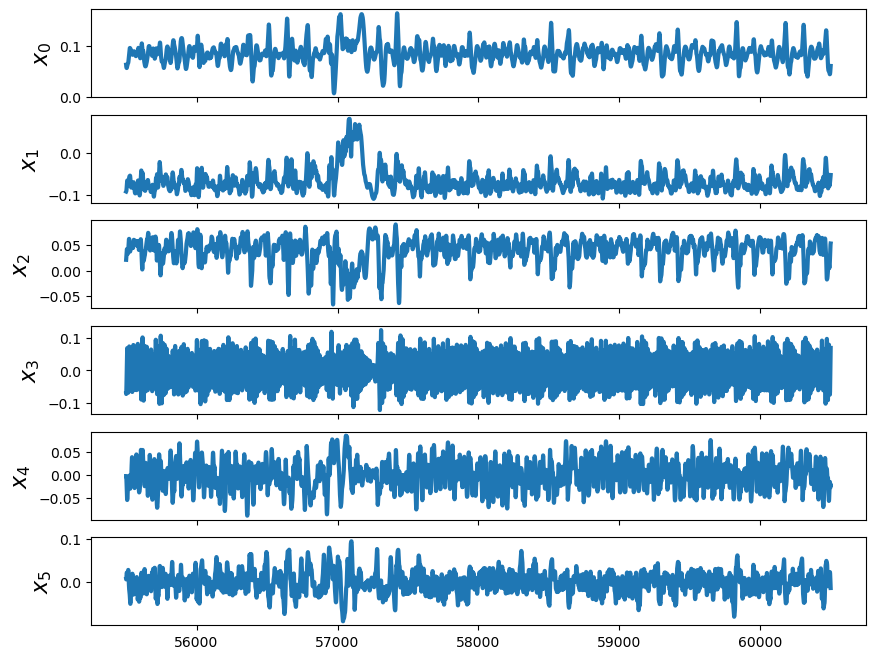

In [9]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
#     ax.set_xlim(54000, 55000)

## B. Generate Observations

In [10]:
# First we need to calculate the per-variable SD for QGS model
obs_sd_scale = 0.1
per_variable_sd = np.std(nr_train.values, axis=0)
obs_sd = 0.1*per_variable_sd

In [11]:
# Now we can define the observer:
obs_qgs_test = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd, 
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Now we can define the observer:
obs_qgs_valid = dab.observer.Observer(
    nr_valid, # Data generator object
    time_indices = np.arange(0, nr_valid.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd,  
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_valid = obs_qgs_valid.observe()
obs_vec_test = obs_qgs_test.observe()

## C. Define and train model

In [12]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=20, 
    reservoir_dim=2000, 
    input_dim=20, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.98765777241154,
    sigma_bias = 0.675882947305197,
    spectral_radius =  0.376752115791648, # SR 
    leak_rate=0.5343730100231164, # alpha
    log_beta=-20.219432227197363)

In [13]:
# # # Train: Takes a few minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('rc_weights.pkl')

In [14]:
# Shortcut: load the W_out weights from previous training
weights_path = 'rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

## D. Set up and run DA Cycler for validation period

In [17]:
# Getting standard deviation of reservoir state values for sigma_bg
train_res_values = forecast_model.generate(nr_train.values)
train_res_sd = np.std(train_res_values, axis=0)

In [19]:
sigma_obs=obs_sd[obs_vec_valid.location_indices[0]]*1.25
sigma_bg = 0.1*train_res_sd 

R = (sigma_obs**2)*np.identity(sigma_obs.shape[0])
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_valid.location_indices[0], 1)] = 1
H = S @ forecast_model.Wout.T

In [21]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_train.values[-1000:]
        + np.random.normal(size = (1000, nr_train.system_dim), scale=obs_sd))[-1], nr_train.values[-1])

In [22]:
def raytune_v4d_bp_valid(config, num_epochs, H, B, R, 
                         delta_t, forecast_model, r0_original,
                         nr, obs_vec, sigma_obs):
    
    dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=config['lr'],
    lr_decay=config['lr_decay'],
    num_epochs=num_epochs,
    model_obj=forecast_model,
    obs_window_indices=[0,2,5,8],
    steps_per_window=10, # 10 instead of 9 because inclusive of start and end
    )
    cur_tstep = 0

    r0_sv = dab.vector.StateVector(
        values=r0_original,
        store_as_jax=True)

    out_statevec = dc.cycle(
        input_state = r0_sv,
        start_time = nr.times[cur_tstep],
        obs_vector = obs_vec,
        analysis_window=4.5,
        timesteps=int(nr_valid.time_dim/9)-2,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=2.25)
        
    rmse = np.sqrt(np.mean(np.square(nr.values[:-19] - forecast_model.readout(out_statevec.values))))
    
    train.report({'rmse':rmse})

### RayTune

In [23]:
space = {
    "lr": hp.loguniform("lr", -10, 0),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.99),
}
num_epochs = 3

In [24]:
trainable_w_num_epochs = tune.with_parameters(raytune_v4d_bp_valid, 
                                              delta_t=nature_run.delta_t,
                                              num_epochs=num_epochs,
                                              H=H,
                                              B=B,
                                              R=R,
                                              forecast_model=forecast_model,
                                              r0_original=r0_original,
                                              sigma_obs=sigma_obs,
                                              obs_vec=obs_vec_valid,
                                              nr=nr_valid
                                             )

trainable_nonparallel = tune.with_resources(trainable_w_num_epochs, {"cpu": 16})

In [25]:
hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min")
tuner = tune.Tuner(
    trainable_nonparallel,
    tune_config=tune.TuneConfig(
        num_samples=50,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()

cur_results_df = results.get_dataframe()

cur_results_df['num_epochs'] = num_epochs

(pid=911367) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=911367)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=911367) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=911367)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=911367) [[  68.54593392   67.05626743   66.6044339 ]
(raytune_v4d_bp_valid pid=911367)  [  46.55327175   46.27681838   46.19138235]
(raytune_v4d_bp_valid pid=911367)  [  46.7386165    46.02137752   45.80022144]
(raytune_v4d_bp_valid pid=911367)  ...
(raytune_v4d_bp_valid pid=911367)  [2741.10200954 2725.92055568 2721.2043169 ]
(raytune_v4d_bp_valid pid=911367)  [3042.84501612 3007.82221395 2996.9329914 ]
(raytune_v4d_bp_valid pid=911367)  [1750.74775474 1730.1070167  1723.70363939]]
(raytune_v4d_bp_valid pid=911367) [[68.54593392 40.58386873 36.98441791]
(raytune_v4d_bp_valid pid=911367)  [55.31066833 39.69080874 35.94236406]
(raytune_v4d_bp_valid pid=911367)  [35.07995793 26.46188764 24.53066234]
(raytune_v4d_bp_valid pid=911367)  ...
(raytune_v4d_bp_valid pid=911367)  [48.22377197 39.69190255 36.86123047]
(raytune_v4d_bp_valid pid=911367)  [45.49953922 40.29160136 37.79751584]
(raytune_v4d_bp_valid pid=911367)  [44.44451124 39.60507406 37.6559474 ]]
(raytune

2024-03-25 23:04:06,618	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_2b479506
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=911367, ip=192.168.0.249, actor_id=72d2cf2f973ede693932a81201000000, repr=raytune

(pid=912062) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=912062)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=912062) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=912062)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=912062) [[   68.54593392    68.39385752    68.24683999]
(raytune_v4d_bp_valid pid=912062)  [ 7875.33963125  7870.28024948  7865.36955224]] [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(raytune_v4d_bp_valid pid=912062)  ...
(raytune_v4d_bp_valid pid=912062)  [12319.58094275 12309.04921296 12298.83651493] [repeated 2x across cluster]
(raytune_v4d_bp_valid pid=912062)  ...
(raytune_v4d_bp_valid pid=912062)  [96.65072891 85.46030764 83.3187848 ]]
(raytune_v4d_bp_valid pid=912062)  [59.09124412 54.63431582 53.62961756] [repeated 5x across cluster]
(raytune_v4d_bp_valid pid=912062) [[  68.54593392   67.61581048   67.11845561]
(raytune_v4d_bp_valid pid=912062)  [  46.7011345    46.52786096   46.43406959]
(raytune_v4d_bp_valid pid=912062)  [  46.92633785   46.47728006   46.23452668]
(raytune_

2024-03-25 23:19:40,259	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_2c4a1d15
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=912062, ip=192.168.0.249, actor_id=e7f7845d53d91f84f543f0bd01000000, repr=raytune

(pid=912807) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=912807)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=912807) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=912807)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:20:03,267	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_e3cd4bcd
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=913006) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=913006)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=913006) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=913006)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:20:25,308	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_aa270313
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=913208) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=913208)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=913208) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=913208)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=913208)  [5730.01625047 5701.4325251  5682.24480306]
(raytune_v4d_bp_valid pid=913208)  [3923.01540436 3907.55592126 3896.98725999]
(raytune_v4d_bp_valid pid=913208)  [9066.82095507 8970.17443687 8904.42570579]]
(raytune_v4d_bp_valid pid=913208) [[  68.54593392   67.60542663   66.97555272]
(raytune_v4d_bp_valid pid=913208)  [  46.78024752   46.3277891    46.02129132] [repeated 2x across cluster]
(raytune_v4d_bp_valid pid=913208)  ...
(raytune_v4d_bp_valid pid=913208) [[ 68.54593392  57.99405139  53.14187196]
(raytune_v4d_bp_valid pid=913208)  ...
(raytune_v4d_bp_valid pid=913208)  [ 87.97934481  81.26142689  77.6081955 ]
(raytune_v4d_bp_valid pid=913208)  [139.35455406 126.34634213 119.93698784]]
(raytune_v4d_bp_valid pid=913208)  [ 91.73146854  86.64130689  83.51763288] [repeated 3x across cluster]
(raytune_v4d_bp_valid pid=913208) [[68.54593392 51.59837488 48.76050468]
(raytune_v4d_bp_valid pid=913208)  [45.36572498 40.87476251 39.80907065]
(raytune_v4d_bp_v

2024-03-25 23:33:13,335	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_50d61802
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=913208, ip=192.168.0.249, actor_id=2ae476eaa4760fbff260018701000000, repr=raytune

(pid=913855) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=913855)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=913855) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=913855)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=913855)  ...
(raytune_v4d_bp_valid pid=913855)  [6214.76417879 6209.83315446 6205.4616489 ]
(raytune_v4d_bp_valid pid=913855) [[  68.54593392   68.40991417   68.28965136]
(raytune_v4d_bp_valid pid=913855)  [  47.60521462   47.53861382   47.47962519] [repeated 2x across cluster]
(raytune_v4d_bp_valid pid=913855)  [3677.97481629 3674.56411672 3671.54450396]] [repeated 2x across cluster]


2024-03-25 23:36:03,861	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_921d3b5d
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=913855, ip=192.168.0.249, actor_id=3c7ab7b14c3a92daf38b806901000000, repr=raytune

(pid=914139) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=914139)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=914139) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=914139)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=914139) [[  68.54593392   65.55677585   63.96277351]
(raytune_v4d_bp_valid pid=914139)  ...
(raytune_v4d_bp_valid pid=914139)  [  45.23809181   43.84386927   43.07387203] [repeated 2x across cluster]
(raytune_v4d_bp_valid pid=914139)  [6349.73879887 6198.4106149  6116.22455486]] [repeated 3x across cluster]
(raytune_v4d_bp_valid pid=914139) [[  68.54593392   59.03271815   55.85308359]
(raytune_v4d_bp_valid pid=914139)  ...
(raytune_v4d_bp_valid pid=914139)  [  42.29866731   38.09479663   36.52459077] [repeated 2x across cluster]
(raytune_v4d_bp_valid pid=914139)  [3237.66338151 3077.61357647 3010.35425524]] [repeated 3x across cluster]
(raytune_v4d_bp_valid pid=914139) [[  68.54593392   68.17402239   68.06221943]
(raytune_v4d_bp_valid pid=914139)  ...
(raytune_v4d_bp_valid pid=914139)  [5598.81942148 5576.63955606 5569.9702566 ]]
(raytune_v4d_bp_valid pid=914139)  [  47.52401451   47.34213342   47.28723347] [repeated 2x across cluster]
(raytune_v4d_bp_valid pi

2024-03-25 23:43:54,619	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_438cee8d
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=914139, ip=192.168.0.249, actor_id=95b5441fe017a59ffabe0e6c01000000, repr=raytune

(pid=914614) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=914614)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=914614) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=914614)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:44:16,487	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_4fed0ce1
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=914812) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=914812)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=914812) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=914812)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:44:38,551	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_c262e45c
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=915016) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=915016)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=915016) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=915016)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:45:00,685	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_b1fbfd34
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=915214) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=915214)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=915214) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=915214)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:45:22,524	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_c2edc429
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=915416) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=915416)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=915416) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=915416)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:45:44,559	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_af641aae
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=915620) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=915620)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=915620) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=915620)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:46:06,328	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_d518005b
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=915826) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=915826)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=915826) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=915826)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:46:28,540	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_9ac3ff27
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916024) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916024)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916024) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916024)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:46:50,506	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_628034f9
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916228) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916228)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916228) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916228)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:12,345	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_9efed763
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916427) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916427)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916427) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916427)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:34,956	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_742cc768
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916631) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916631)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916631) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916631)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:56,695	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_30e9526a
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916830) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916830)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916830) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916830)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:48:18,791	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_7dcc51f4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917031) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917031)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917031) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917031)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:48:40,416	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_71880dfb
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917234) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917234)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917234) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917234)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:02,677	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_3fcdbdf4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917430) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917430)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917430) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917430)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:24,859	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_f6d4c261
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917634) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917634)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917634) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917634)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:46,977	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_b05bc1fb
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917835) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917835)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917835) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917835)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:09,008	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_57d1baa5
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918040) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918040)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918040) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918040)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:31,057	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_69c9ce65
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918239) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918239)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918239) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918239)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:53,118	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_17b727d5
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918448) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918448)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918448) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918448)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:14,921	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_e9390817
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918646) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918646)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918646) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918646)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:36,937	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_da9a96f8
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918848) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918848)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918848) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918848)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:58,993	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_a1c49c76
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=919045) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=919045)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=919045) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=919045)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:52:20,967	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_82846bf4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

2024-03-25 23:52:21,016	ERROR tune.py:1043 -- Trials did not complete: [raytune_v4d_bp_valid_2b479506, raytune_v4d_bp_valid_2c4a1d15, raytune_v4d_bp_valid_e3cd4bcd, raytune_v4d_bp_valid_aa270313, raytune_v4d_bp_valid_50d61802, raytune_v4d_bp_valid_921d3b5d, raytune_v4d_bp_valid_438cee8d, raytune_v4d_bp_valid_4fed0ce1, raytune_v4d_bp_valid_c262e45c, raytune_v4d_bp_valid_b1fbfd34, raytune_v4d_bp_valid_c2edc429, raytune_v4d_bp_valid_af641aae, raytune_v4d_bp_valid_d518005b, raytune_v4d_bp_valid_9ac3ff27, raytune_v4d_bp_valid_628034f9, raytune_v4d_bp_valid_9efed763, raytune_v4d_bp_valid_742cc768, raytune_v4d_bp_valid_30e9526a, raytune_v4d_bp_valid_7dcc51f4, raytune_v4d_bp_valid_71880dfb, raytune_v4d_bp_valid_3fcdbdf4, raytune_v4d_bp_valid_f6d4c261, raytune_v4d_bp_valid_b05bc1fb, raytune_v4d_bp_valid_57d1baa5, raytune_v4d_bp_valid_69c9ce65, raytune_v4d_bp_valid_17b727d5, raytune_v4d_bp_valid_e9390817, raytune_v4d_bp_valid_da9a96f8, raytune_v4d_bp_valid_a1c49c76, raytune_v4d_bp_valid_82846bf4

In [26]:
cur_results_df.to_csv('./out/qgs/test_raytune_qgs_v4_hessian.csv')